In [103]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [104]:
# Load data
query_img = cv.imread('data/1.jpg')
train_img = cv.imread('data/2.jpg')

In [105]:
sift = cv.SIFT_create()
# Extract SIFT key points and features
kp1, des1 = sift.detectAndCompute(query_img, None)
kp2, des2 = sift.detectAndCompute(train_img, None)


# Compute matches
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
ratio = 0.5
good_points = []
for m,n in matches:
    distance_ratio = m.distance / n.distance
    if distance_ratio > ratio :
        good_points.append([m, distance_ratio])
 
# sort matches to get 
matches = np.array(good_points)
idx = np.argsort(-matches[:, 1])
matches = matches[idx]

dst_pts = []
src_pts = []
for i, m in enumerate(matches):
    # only take first value of m because second value is the distance
    dst_pts.append(kp1[m[0].queryIdx].pt)
    src_pts.append(kp2[m[0].trainIdx].pt)


src_pts = np.array(src_pts).astype(np.float32)
dst_pts = np.array(dst_pts).astype(np.float32)


[[-4.28312926e-01 -1.07292706e+00  7.81528210e+02]
 [-2.37329758e-01 -5.39489842e-01  3.99414941e+02]
 [-5.30944422e-04 -1.31029601e-03  1.00000000e+00]]
1179.6632495394772


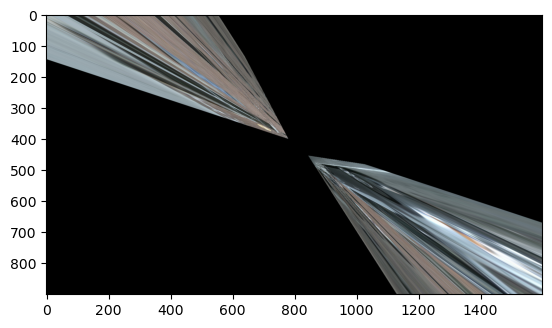

In [112]:

A = []
for x, x_prime in zip(src_pts, dst_pts):
    # maybe x and y need to be swapped
    # s = xy, d = x'y'
    A.append([x[0], x[1], 1, 0, 0, 0, -x_prime[0]*x[0],  -x_prime[0]*x[1], -x_prime[0]])
    A.append([0, 0, 0, x[0], x[1], 1, -x_prime[1]*x[0],  -x_prime[1]*x[1], -x_prime[1]])
A = np.array(A)

U, S, V = np.linalg.svd(A, full_matrices=True)
# take lowest eigval for the eigenvector that is our homography
H = V[-1].reshape(3, 3) / V[-1, -1]
print(H)
print(H.sum())

train_warp = cv.warpPerspective(train_img, H, (query_img.shape[1], query_img.shape[0]))

_, ax = plt.subplots(1, 1)
train_warp = cv.cvtColor(train_warp, cv.COLOR_BGR2RGB)
ax.imshow(train_warp)


Somehow my manually made method for homography does not seem to work. Try another

In [107]:
# taken from 
# https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b
def find_homography(points_source, points_target):
    A  = construct_A(points_source, points_target)
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    
    # Solution to H is the last column of V, or last row of V transpose
    homography = vh[-1].reshape((3,3))
    return homography/homography[2,2]

def construct_A(points_source, points_target):
    assert points_source.shape == points_target.shape, "Shape does not match"
    num_points = points_source.shape[0]

    matrices = []
    for i in range(num_points):
        partial_A = construct_A_partial(points_source[i], points_target[i])
        matrices.append(partial_A)
    return np.concatenate(matrices, axis=0)

def construct_A_partial(point_source, point_target):
    x, y, z = point_source[0], point_source[1], 1
    x_t, y_t, z_t = point_target[0], point_target[1], 1

    A_partial = np.array([
        [0, 0, 0, -z_t*x, -z_t*y, -z_t*z, y_t*x, y_t*y, y_t*z],
        [z_t*x, z_t*y, z_t*z, 0, 0, 0, -x_t*x, -x_t*y, -x_t*z]
    ])
    return A_partial

[[-4.28312926e-01 -1.07292706e+00  7.81528210e+02]
 [-2.37329758e-01 -5.39489842e-01  3.99414941e+02]
 [-5.30944422e-04 -1.31029601e-03  1.00000000e+00]]
1179.6632495373149


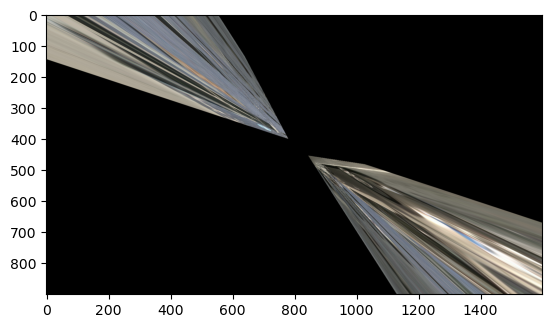

In [108]:
homo = find_homography(src_pts, dst_pts)
print(homo)
print(homo.sum())
im_out = cv.warpPerspective(train_img, homo, (query_img.shape[1], query_img.shape[0]))
plt.imshow(im_out)
plt.show()

Sample Solution by using homography from opencv

[[ 7.47883632e-01  4.73916581e-02  4.22976479e+02]
 [ 3.23715962e-04  8.65783793e-01  6.34513552e+01]
 [-5.17899836e-06  3.27059852e-05  1.00000000e+00]]
489.08924498906833


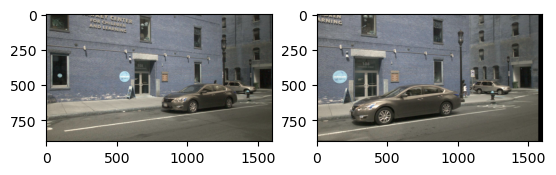

In [98]:
homo, mask= cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
inv_homo, mask= cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
print(homo)
print(homo.sum())
im_out = cv.warpPerspective(train_img, homo, (query_img.shape[1], query_img.shape[0]))
im_back = cv.warpPerspective(im_out, inv_homo, (query_img.shape[1], query_img.shape[0]))

ax[1].imshow(im_back)
plt.show()

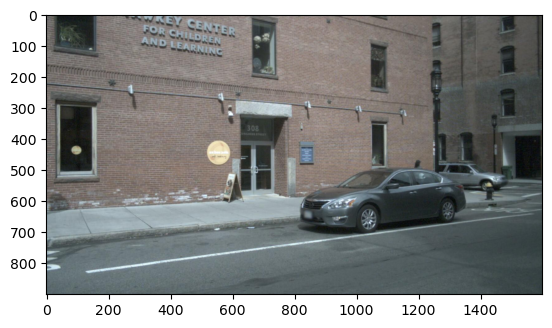

In [102]:
# Projection matrixs for query_img and train_img
P_q = np.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0],
                [0, 0, 1.0, 0]])

P_t = np.array([[1.0, 0, 0, 1],
                [0, 1.0, 0, 1],
                [0, 0, 1.0, 0]])

# Compute 3D points

# Visualization

# simply overlap both images
im_out = cv.cvtColor(im_out, cv.COLOR_BGR2RGB)
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)

plt.imshow(im_out)
plt.imshow(query_img)
